- Harris: apply gaussian, compute the matrix M (gradient), compute the Harris and that's all, that's easy

In [1]:
from pathlib import Path
import numpy as np
from numpy.linalg import det
import matplotlib.pyplot as plt
from PIL import Image

from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
import cv2

import gzip 
import sys
import pickle

In [2]:
data_dir = Path("./rubiks_cube_photos")

In [3]:
def load_data():
    # Loop over all the files in the data directory
    data = []
    for file in list(data_dir.rglob("*.jpg")) + list(data_dir.rglob("*.JPG")):
        # Load the image
        img = Image.open(file).convert("L")
        # Resize to 128x128
        img = img.resize((128, 128))
        # Convert to numpy array
        img = np.array(img)
        # Append to the list of images
        data.append({
          'img': img,
          'name': file.name,  
        })
    return data

In [4]:
def compute_gradients(image):
    Gx_filter = np.array([[1,0,-1],
                        [2,0,-2],
                        [1,0,-1]])

    Gy_filter = np.array([[1,2,1],
                         [0,0,0],
                         [-1,-2,-1]])

    grad_x = convolve2d(image, Gx_filter, mode='same')
    grad_y = convolve2d(image, Gy_filter, mode='same')

    return grad_x, grad_y

In [5]:
class HarrisDetector:
    img_sigma = 1
    grad_sigma = 0.6
    threshold = 0.01

    def __init__(self):
        self.R = None

    def harris_detection(self, image):
        filtered_image = gaussian_filter(image, sigma=self.img_sigma)
        Ix, Iy = compute_gradients(filtered_image)
        Ixx = Ix**2
        Iyy = Iy**2
        Ixy = Ix*Iy
        Ixx = gaussian_filter(Ixx, sigma=self.grad_sigma)
        Iyy = gaussian_filter(Iyy, sigma=self.grad_sigma)
        Ixy = gaussian_filter(Ixy, sigma=self.grad_sigma)
        det = Ixx*Iyy - Ixy**2
        trace = Ixx + Iyy
        R = det - 0.04*trace**2
        R = self.non_max_supression(R)
        
        self.R = R
        
        return self
    
    def non_max_supression(self, R):
        xx, yy = np.where(R > self.threshold*R.max())
        R = np.where(R > self.threshold*R.max(), R, 0)

        for x, y in zip(xx, yy):
            if x < 5 or y < 5 or x > R.shape[0]-5 or y > R.shape[1]-5:
                R[x,y] = 0
                continue
            values = R[x-5:x+5,y-5:y+5]
            R[x-5:x+5,y-5:y+5] = np.where(values == values.max(), values, 0)

        return R
    
    def draw_corners(self, image):
        plot_image = np.expand_dims(image, 2).repeat(3, 2)
        for x, y in zip(*self.get_corners()):
            cv2.circle(plot_image,(y, x), int(self.threshold*max(plot_image.shape)), (255,0,0), -1)

        return plot_image
    
    def get_corners(self):
        return np.where(self.R > self.threshold*self.R.max())

In [6]:
data = load_data()

In [7]:
len(data)

48

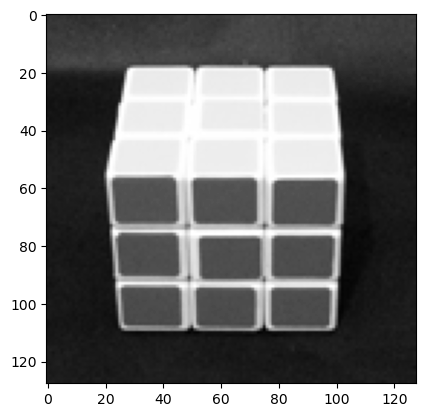

In [8]:
img = data[15]['img']

plt.imshow(img, cmap='gray')

In [9]:
def orientation_binning(magnitude, orientation, cell_size, num_bins=4):
    # Initialize the bins for the entire image
    bin_edges = np.linspace(0, 360, num_bins+1, endpoint=True)
    cell_rows, cell_cols = magnitude.shape[0] // cell_size[0], magnitude.shape[1] // cell_size[1]
    hog_vector = np.zeros((cell_rows, cell_cols, num_bins))
    
    # Process each cell
    for i in range(cell_rows):
        for j in range(cell_cols):
            cell_magnitude = magnitude[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            cell_orientation = orientation[i*cell_size[0]:(i+1)*cell_size[0], j*cell_size[1]:(j+1)*cell_size[1]]
            
            # Bin the orientations within the cell
            for b in range(num_bins):
                bin_mask = (cell_orientation >= bin_edges[b]) & (cell_orientation < bin_edges[b+1])
                hog_vector[i, j, b] = np.sum(cell_magnitude[bin_mask])
    
    # Flatten the HOG vector for the entire image
    hog_vector = hog_vector.ravel()
    
    # Normalize the histogram
    norm = np.linalg.norm(hog_vector)
    if norm != 0:
        hog_vector /= norm
    
    return hog_vector

def hog_descriptor(image, cell_size=(8, 8), num_bins=4):
    grad_x, grad_y = compute_gradients(image)
    magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    orientation = np.arctan2(grad_y, grad_x) * (180 / np.pi)
    orientation = np.mod(orientation, 360) 
    hog_vector = orientation_binning(magnitude, orientation, cell_size, num_bins)
    return hog_vector

In [10]:
def extract_subimage(img, center_ix, size):
    # Compute the top-left corner of the image
    x = int(center_ix[0] - size/2)
    y = int(center_ix[1] - size/2)
    
    # Extract the image
    subimage = img[x:x+size, y:y+size]
    
    return subimage

In [11]:
def extract_image_features(image):
    harris = HarrisDetector().harris_detection(image)
    corner_xx, corner_yy = harris.get_corners()

    image_features = []
    for x, y in zip(corner_xx, corner_yy):
        subimage = extract_subimage(img, (x, y), 16)
        hog_features = hog_descriptor(subimage, cell_size=(8, 8), num_bins=4)
        image_features.append(hog_features.reshape(1, -1))
    image_features = np.concatenate([arr for arr in image_features if arr.shape==(1,16)], axis=0)
    return image_features

In [12]:
harris = HarrisDetector().harris_detection(img)

In [13]:
plot_image = harris.draw_corners(img)

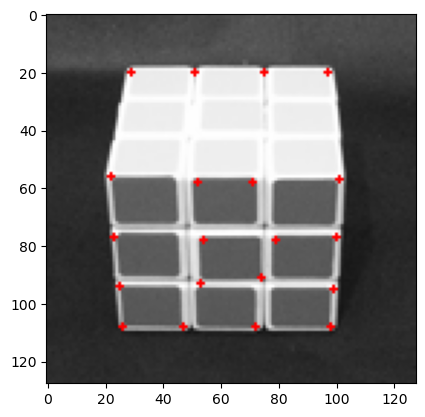

In [14]:
plt.imshow(plot_image)

In [15]:
all_features = []
for dic in data:
    image = dic['img']
    image_features = extract_image_features(image)
    dic['features'] = image_features
    all_features.append(image_features)

all_features = np.concatenate(all_features, axis=0)

In [16]:
from sklearn.cluster import KMeans

In [17]:
model = KMeans(n_clusters=6, random_state=0).fit(all_features)

In [18]:
for dic in data:
    clusters = model.predict(dic['features'])
    dic['hist'] = [0]*6
    for cluster in clusters:
        dic['hist'][cluster] += 1

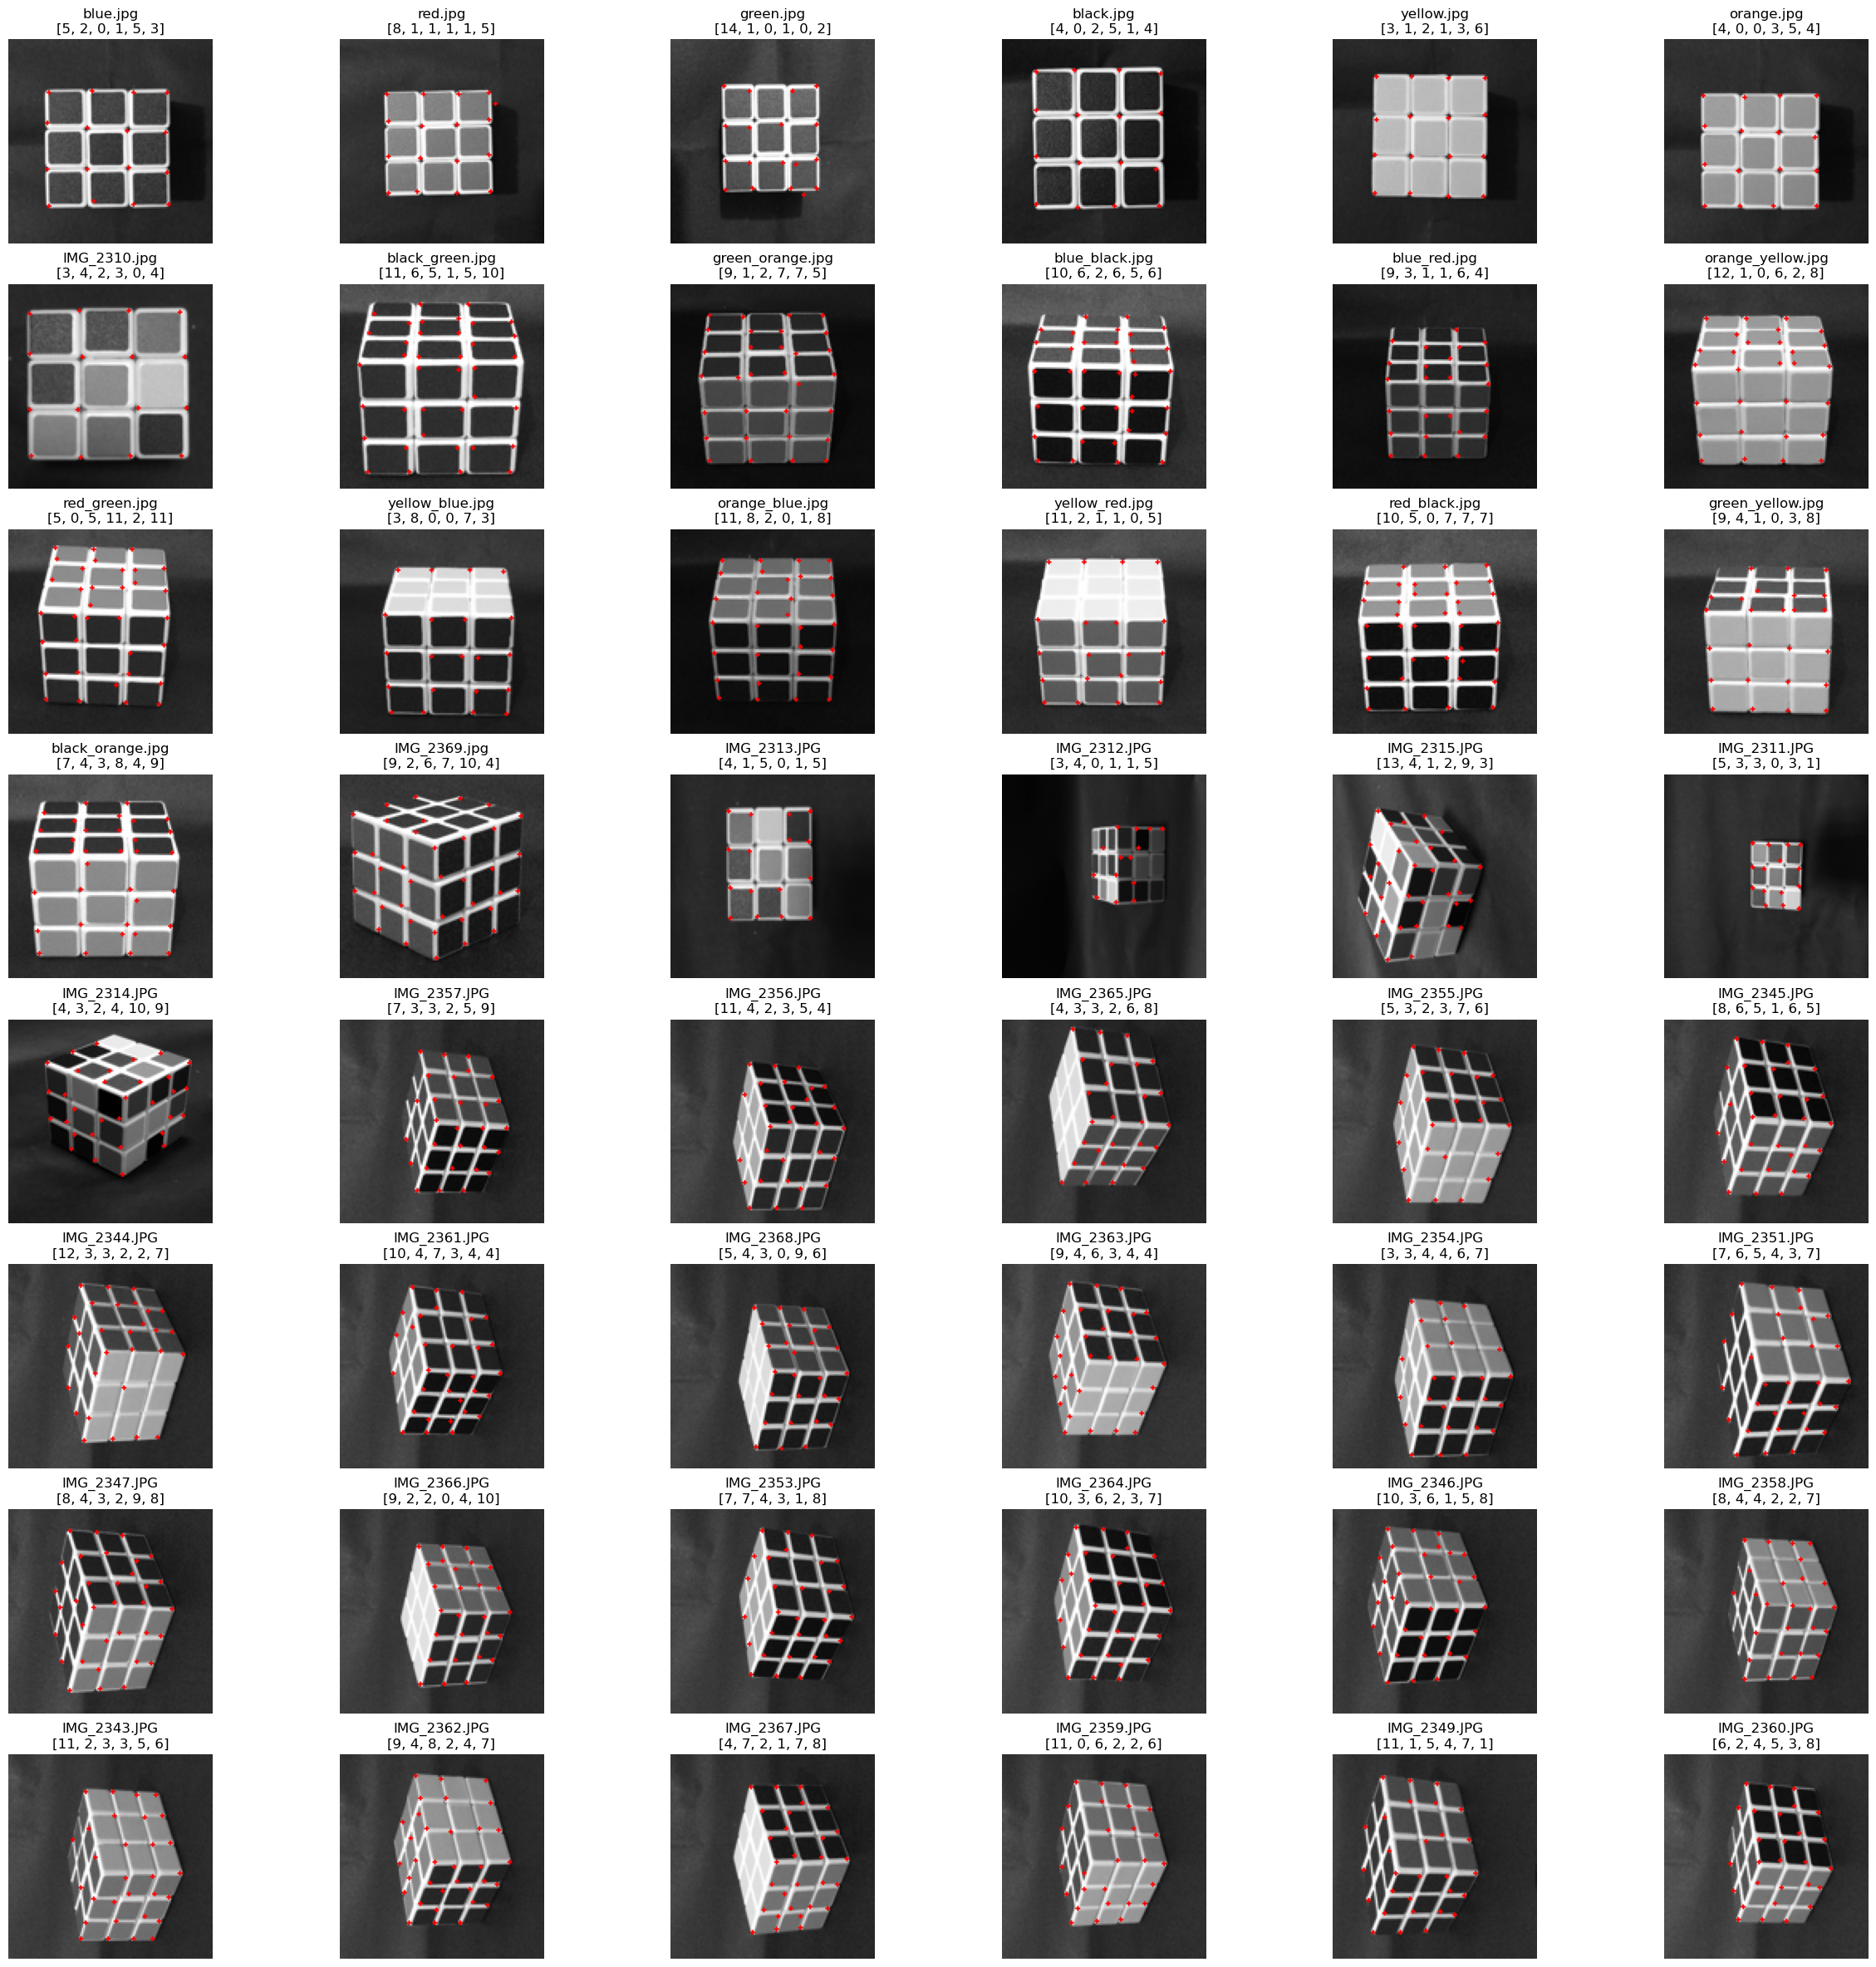

In [19]:
fig, axs = plt.subplots(8, 6, figsize=(30, 30))

for i, dic in enumerate(data):
    plot_image = HarrisDetector().harris_detection(dic['img']).draw_corners(dic['img'])
    axs[i//6, i%6].imshow(plot_image, cmap='gray')
    axs[i//6, i%6].set_title(f"{dic['name']}\n{dic['hist']}")
    axs[i//6, i%6].axis('off')